In [1]:
!nvidia-smi

Mon Dec 21 00:06:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   57C    P0    61W / 149W |      0MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
 #!pip3 install transformers

In [3]:
#!pip3 uninstall nltk --yes
#!pip3 install nltk 

In [4]:

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertForMaskedLM, TFTrainer, TFTrainingArguments, pipeline
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np
import nltk
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu
from nltk.translate.nist_score import sentence_nist, corpus_nist
from nltk.translate.meteor_score import meteor_score
import sys
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from tqdm.notebook import tqdm

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#tomada de tempo de excução
runStart = datetime.now()

In [6]:
#
# MODO DE EXECUÇÃO DO NOTEBOOK
#
# Para evitar consumo de máquina e tempo este notebook pode ser executado de duas formas.
#
# False = usa pesos e outros parâmetros salvos. Não roda otimizações, usa do modelo
#       ja salvo, mas roda cálculos e gráficos.
#
# True = roda o notebook inteiro: todas otimizações, cálculos e gráficos.
#
#
RUN_MODE = True

In [7]:
TEXT_MAXLEN = 60
TITLE_MAXLEN = 10

max_length_review = 60
max_length_title = 10

TEXT_MAX_NB_WORDS = 60
TITLE_MAX_NB_WORDS = 5

CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
EOS = '[SEP]'
#EOS = '[unused99]'
SPC = ' '

frac_corpus = .01

EPOCHS = 1
BATCH_SIZE = 64

In [8]:
#Importação do CORPUS no mesmo diz local no formato tsv
b2wCorpus = pd.read_csv('b2wCorpusFull.tsv',"\t",usecols=['review_title','review_text'], encoding='utf-8')# ,nrows=100)
b2wCorpus = b2wCorpus.rename(columns={'review_title': 'title', 'review_text': 'review'})
lines = len(b2wCorpus.index)
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível, ótima qualidade","por apenas r$1994.20,eu consegui comprar esse ..."
2,atende todas as expectativa.,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou! parece de verdade com tantos d...
4,"sem duvidas, excelente","a entrega foi no prazo, as americanas estão de..."


In [9]:
lines

132373

In [10]:
# Pré-processamento
def cleanning(text, stem=False):
  text = text.replace("@"," ")
  text = re.sub('[*)@#%(&$_^~]', '', text)
  text = re.sub(r'([?!.])\1+', r'\1', text)
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  text = re.sub("\d+", "", text).strip()
  return text

In [11]:
b2wCorpus.review = b2wCorpus.review.apply(lambda x: cleanning(x))
b2wCorpus.title = b2wCorpus.title.apply(lambda x: cleanning(x))
b2wCorpus.drop_duplicates(subset=['review'], inplace=True)
b2wCorpus.dropna(axis=0,inplace=True)
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível , ótima qualidade","por apenas r . , eu consegui comprar esse lin..."
2,atende todas as expectativa .,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou ! parece de verdade com tantos ...
4,"sem duvidas , excelente","a entrega foi no prazo , as americanas estão d..."


In [12]:
# Recorte do corpus baseado no max_length_review e no max_length_title
b2wCorpus=b2wCorpus.sample(frac=1).reset_index(drop=True)
def tamanho(text):
    return len(text.split())
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) > 3]
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) <= max_length_review]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) > 0 ]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) <= max_length_title]

In [13]:
b2wCorpus.shape

(116780, 2)

In [14]:
# Atualizando tamanho, index e suffling do dataframe do corpus

lines = int(lines * frac_corpus)
b2wCorpus=b2wCorpus.head(lines)
b2wCorpus=b2wCorpus.sample(frac=1).reset_index(drop=True)
b2wCorpus.shape

(1323, 2)

In [15]:
b2wCorpus.head(200)

,title,review
0,satisfeita .,muito satisfeita com o produto . tive alguns c...
1,bom produto,tudo ok ! precisava para colocar os apps do an...
2,melhor presente de aniversário do mundo !,tipo o preço é meio salgado mas vale o investi...
3,muito satisfeita,"nao é a primeira vez que compro com a wb , são..."
4,ainda não recebi,"não recebi ainda , consegue me informar qd vai..."
...,...,...
195,amei o produto,"recebi dentro do prazo , super bem embalado , ..."
196,ótimo custo benefícicio,o celular é maravilhoso para o preço . a câmer...
197,médio,"a cadeira é confortável , mas o cinto da crian..."
198,ótima qualidade,"produto bonito , de qualidade e entrega super ..."


In [16]:
def generate_pairs(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate pairs for summary task
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        pairs (list of strings, list of strings) : pairs with lists of strings of 
        text and title 
    '''
    pairs = []
    text_truncated = ' '.join(text.split()[:text_max_nb_words])
    title_truncated = ' '.join(title.split()[:title_max_nb_words]) + SPC + EOS + SPC
    spl = title_truncated.split()

    for w in range(len(spl)):
        # new_text = CLS + SPC + text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK + SPC + SEP
        new_text = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + MASK
        # pairs.append([new_text, spl[w]])
        new_output = text_truncated + SPC + SEP + SPC + ' '.join(spl[:w]) + SPC + spl[w]
        pairs.append([new_text, new_output])
        
    return pairs

In [17]:
def generate_samples(text, title, text_max_nb_words=None, title_max_nb_words=None):
    '''
    Generate samples for summary task - helper function
    with bert
    Args:
        text (numpy:list) : numpy array with lists of text reviews
        title (numpy:list) : numpy array with lists of title reviews
        text_max_nb_words (int) : max number of words to truncate text review
        title_max_nb_words (int) : max number of words to truncate title review
    returns:
        (text, title) (list of strings, list of strings) :  samples
    '''
    new_text = []
    new_title = []
    
    for i in range(len(text)):
        pairs = generate_pairs(text[i], title[i], text_max_nb_words, title_max_nb_words)
        new_text.extend([sample[0] for sample in pairs])
        new_title.extend([sample[1] for sample in pairs])
    
    return new_text, new_title

In [18]:
def tokenize(sentences, tokenizer=None, ref_model = None, maxlen=50, add_special_tokens=True):
    '''
    Encodes a string to an array of integers

    Args:
        sentences (list): list of human-readable strings to encode  
        tokenizer () : Bert tokenizer instance
        ref_model (str) : bert reference model
        maxlen (int) : max length of a sequence to pad and truncate
    Returns:
        (dict : numpy array) input_ids, token_type_ids, attention_mask
        Tokenizer: Bert tokenizer instance
    '''
    # Bert Tokenizer
    if tokenizer is None:
      tokenizer = BertTokenizer.from_pretrained(ref_model)
      tokenizer.eos_token = EOS
      # tokenizer = BertTokenizer.from_pretrained(ref_model, eos_token=EOS) # Não funciona a loss da nan
    
    # tokenizer.add_tokens([EOS]) # Não funciona a loss da nan
    
    encoded = tokenizer(
        [[line] for line in sentences],
        text_pair=None,
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_tensors='np',
        add_special_tokens=add_special_tokens)
    
    return encoded, tokenizer

In [19]:
def predict_and_decode_sequences(data, model, sent_max_len, sent_max_nb_words, seq_max_len, tokenizer):
  '''
  Predicts the title review given
  a text review sentence.
  args:
    data (list:str) or (numpy array:str) - list/array 
    of human readable strings

    model (keras model) : keras model used to predict
    the sentence title review
    
    sent_max_len (int) : max number of characters of the
    predicted sentence

    sent_max_nb_words (int) : max number of words of the
    predicted sentence

    seq_max_len (int) : sequence max length

    tokenizer (Bert pretreined tokenizer) - Bert tokenizer

  returns:
    sentences (list:str) : list of predicted titles
  '''

  sentences = []
  with tqdm(total=len(data)) as pbar:
    for sentence in data:
      next_sent = ' '.join(sentence.split()[:sent_max_nb_words]) + SPC + SEP + MASK
      result = ''
      predicted_word = ''

      while len(result) <= sent_max_len and predicted_word != EOS:
        # Tokenize sentence and get the index of [MAK]
        # tokenized_sent = tok(next_sent)
        tokenized_sent, _ = tokenize([next_sent], tokenizer, maxlen=seq_max_len)
        mask_idx = np.where(tokenized_sent['input_ids'][0] == tokenizer.mask_token_id)[0]
        if len(mask_idx) == 0:
          break
        mask_idx = mask_idx[0]
        # Make prediction and get the word indexes
        pred = model.predict([tokenized_sent['input_ids'], tokenized_sent["attention_mask"]])
        prediction = np.argmax(pred.logits, axis=-1)
        # decode predicted sequence to human readable string
        new_sent = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(prediction[0][0:mask_idx]))
        predicted_word = tokenizer.ids_to_tokens[int(prediction[0][mask_idx-1])]

        if predicted_word != EOS:
          result = result + predicted_word + ' '
        # make the new sentence ready for a new prediction
        next_sent = new_sent + SPC + MASK
      sentences.append(result.strip())
      pbar.update(1)
  return sentences

In [20]:
review_text_ = b2wCorpus['review'].values
title_text_ = b2wCorpus['title'].values

In [21]:
# Print de amostra do titulo e do review
for j in range(9):
    print("\n\ntitle: " + title_text_[j])
    print("\nreview: " +  review_text_[j])



title: satisfeita .

review: muito satisfeita com o produto . tive alguns contra tempos com a entrega , mas ocorreu tudo bem no final .


title: bom produto

review: tudo ok ! precisava para colocar os apps do android nele , e deu certo ,


title: melhor presente de aniversário do mundo !

review: tipo o preço é meio salgado mas vale o investimento pois este foi o melhor presente de aniversário que eu já dei a alguém , verdade seja dita estamos rindo até agora das reações após o desembrulho do presente .


title: muito satisfeita

review: nao é a primeira vez que compro com a wb , são muito confiáveis , produto chega muito bem embalado e certinho .


title: ainda não recebi

review: não recebi ainda , consegue me informar qd vai chegar ?


title: muito bom produto !

review: produto chegou antes do prazo estimado , qualidade muito boa ! recomendo !


title: ótimo produto

review: ótimo smartphone , entrega feita antes do prazo previsto .


title: amei meu grill e sanduicheira

review

In [22]:
# Função de split de dados
def train_validate_test_split(df, train_percent=.70, validate_percent=.15, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [23]:
# Split
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

# Criação das séries
# Treino, Validação e Teste
X_train =  b2wCorpusTrain.review.values.tolist()
y_train =  b2wCorpusTrain.title.values.tolist()

X_val = b2wCorpusValidate.review.values.tolist()
y_val = b2wCorpusValidate.title.values.tolist()

X_test = b2wCorpusTest.review.values.tolist()
y_test = b2wCorpusTest.title.values.tolist()

len(X_train),len(X_val), len(X_test)


(926, 198, 199)

In [24]:
X_test_inf = X_test.copy()
y_test_inf  = y_test.copy()

In [25]:
X_train, y_train = generate_samples(X_train, y_train, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
X_val, y_val = generate_samples(X_val, y_val, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)
X_test, y_test = generate_samples(X_test, y_test, TEXT_MAX_NB_WORDS, TITLE_MAX_NB_WORDS)

In [26]:
for i in range(15):
    print(X_train[i], '\n', y_train[i]) 
    print('\n\n')

os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode ser classificado como excelente . [SEP]  [MASK] 
 os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode ser classificado como excelente . [SEP]  pode



os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode ser classificado como excelente . [SEP] pode [MASK] 
 os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode ser classificado como excelente . [SEP] pode melhorar



os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode ser classificado como excelente . [SEP] pode melhorar [MASK] 
 os pés , extremamente baixos , não permitem a limpeza abaixo da máquina . se esse detalhe for melhorado , o produto pode s

In [27]:
SEQUENCE_MAXLEN = TEXT_MAXLEN + TITLE_MAXLEN + 2
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'

X_train, X_train_tokenizer = tokenize(X_train, None, REF_MODEL, SEQUENCE_MAXLEN)
X_val, _ = tokenize(X_val, X_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)
X_test, _ = tokenize(X_test, X_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN)

y_train, y_train_tokenizer = tokenize(y_train, None, REF_MODEL, SEQUENCE_MAXLEN, False)
y_val, _ = tokenize(y_val, y_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)
y_test, _ = tokenize(y_test, y_train_tokenizer, REF_MODEL, SEQUENCE_MAXLEN, False)

In [28]:
TEXT_VOC_SIZE = len(X_train_tokenizer.get_vocab())
TITLE_VOC_SIZE = len(y_train_tokenizer.get_vocab())

In [29]:
print('Shapes dos conjuntos após realizar todas as etapas necessárias')
print()
print('TEXT')
print('=======================')
print('Train:', X_train['input_ids'].shape)
print('Val:  ',X_val['input_ids'].shape)
print('Test: ', X_test['input_ids'].shape)
print('=======================')
print()
print('TITLE:')
print('=======================')
print('Train: ', y_train['input_ids'].shape)
print('Val:   ', y_val['input_ids'].shape)
print('Test   ', y_test['input_ids'].shape)
print('=======================')

Shapes dos conjuntos após realizar todas as etapas necessárias

TEXT
Train: (3462, 72)
Val:   (770, 72)
Test:  (710, 72)

TITLE:
Train:  (3462, 72)
Val:    (770, 72)
Test    (710, 72)


In [30]:
print('Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas')
print()
print('=======================')
print('Text:', TEXT_VOC_SIZE, 'palavras')
print('=======================')
print()
print('=======================')
print('Title:', TITLE_VOC_SIZE, 'palavras')
print('=======================')

Tamanho dos vocabulários - Vocabulários restritos ao conjunto de treino apenas

Text: 29794 palavras

Title: 29794 palavras


In [31]:
# CLS = '[CLS]'
# SEP = '[SEP]'
# MASK = '[MASK]'
# EOS = '[SEP]'
# #EOS = '[unused99]'
# SPC = ' '
# REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
# tokenizer = BertTokenizer.from_pretrained(REF_MODEL)
# print(REF_MODEL)
# print('[CLS]',tokenizer.convert_tokens_to_ids(['[CLS]']))
# print('[SEP]',tokenizer.convert_tokens_to_ids(['[SEP]']))
# print('[MASK]',tokenizer.convert_tokens_to_ids(['[MASK]']))
# print('[EOS]',tokenizer.convert_tokens_to_ids(['[EOS]']))
# print(tokenizer.convert_ids_to_tokens([104]))
# print(tokenizer.convert_ids_to_tokens([105]))
# # print(tokenizer.eos_token_id)
# frase = "Ricardo gostei de água.[SEP] Veio com defeito[MASK]. Eu gostei muito do produto."
# a = tokenizer.encode(frase,add_special_tokens=False)
# print(a)
# b = tokenizer.convert_ids_to_tokens(a)
# print(b)
# c = tokenizer.convert_tokens_to_string(b)
# print(c)
# #predicted_word = tokenizer.ids_to_tokens(a)
# REF_MODEL = 'bert-base-uncased'
# print(REF_MODEL)
# tokenizer = BertTokenizer.from_pretrained(REF_MODEL )
# print(tokenizer.cls_token_id, tokenizer.sep_token_id,tokenizer.eos_token_id,tokenizer.mask_token_id)
# print('[CLS]',tokenizer.convert_tokens_to_ids(['[CLS]']))
# print('[SEP]',tokenizer.convert_tokens_to_ids(['[SEP]']))
# print('[MASK]',tokenizer.convert_tokens_to_ids(['[MASK]']))
# print('[EOS]',tokenizer.convert_tokens_to_ids(['[EOS]']))
# print(tokenizer.convert_ids_to_tokens([104]))
# print(tokenizer.convert_ids_to_tokens([105]))




In [32]:

# Rede: arquitetura, configurações, parâmetros e otimização
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
with tf.device('GPU:0'):
    from keras import backend as K 
    #K.clear_session() 

    bert_model = TFBertForMaskedLM.from_pretrained(REF_MODEL, from_pt=True)
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
    input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')
    X = bert_model(input_ids, input_masks_ids)

    # Definição da model
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
    model.summary()
    plot_model(model, to_file='Bert_train_model.png', show_shapes=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-07)
    my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)]
    model.compile(opt, loss, metrics=[metric])
    if RUN_MODE:
        history = model.fit(
                [X_train["input_ids"],
                X_train["attention_mask"]],
                y_train["input_ids"],
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=my_callbacks,
                validation_data = ([X_val["input_ids"],
                                X_val["attention_mask"]],
                                y_val["input_ids"])
        )
        with open('BERT_history.history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        with open('BERT_history.history', 'rb') as file_pi:
            history = pickle.load(file_pi)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
/anaconda/envs/ep3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarni

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 72)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 72)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_masked_lm (TFBertFo TFMaskedLMOutput(los 109545058   input_token[0][0]                
Total params: 109,545,058
Trainable params: 109,545,058
Non-trainable params: 0
__________________________________________________________________________________________________
55/55 [==============================] - 123s 2s/step - loss: 5.7149 - accuracy: 0.3996 - val_loss: 2.5667 - val_

In [33]:
if RUN_MODE:
    model.evaluate([X_test["input_ids"],
                    X_test["attention_mask"]], 
                y_test["input_ids"])

23/23 [==============================] - 9s 370ms/step - loss: 2.5752 - accuracy: 0.5968


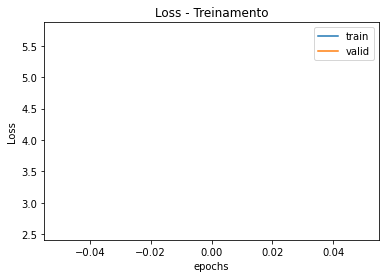

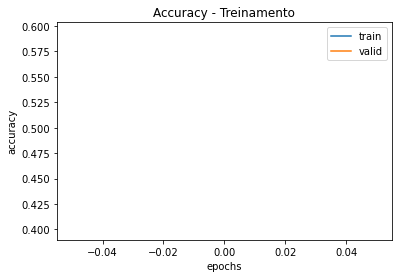

<Figure size 432x288 with 0 Axes>

In [34]:
# Gráfico da loss e da acurácia
import matplotlib.pyplot as plt 
plt.title('Loss - Treinamento')
plt.xlabel('epochs')
plt.ylabel('Loss')
if RUN_MODE:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
else:
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='valid')
plt.legend()
plt.show()
plt.clf()

plt.title('Accuracy - Treinamento')
plt.xlabel('epochs')
plt.ylabel('accuracy')
if RUN_MODE:
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
else:
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='valid')
plt.legend()
plt.show()
plt.clf()

In [35]:
if RUN_MODE:
    y_pred = predict_and_decode_sequences(X_test_inf, model, TITLE_MAXLEN, TEXT_MAX_NB_WORDS, SEQUENCE_MAXLEN, X_train_tokenizer)

In [36]:
if RUN_MODE:
    for i in range(1, 100):
        print("Text Review:", X_test_inf[i])
        print("Original Title Review:", y_test_inf[i])
        print("Predicted Title Review:", y_pred[i])
        print("\n")

Text Review: o jato é muito fraco , deveria ser mais potente além disso tem que colocar o aparelho no alto .
Original Title Review: regular
Predicted Title Review: o o o o o o


Text Review: adoro os produtos da modare , são muito confortáveis .
Original Title Review: modare
Predicted Title Review: de de de de


Text Review: quebrou em  dias de uso , já faz  dias que está no conserto e sem previsão de entrega
Original Title Review: produto ruim
Predicted Title Review: [PAD] , , ,


Text Review: ótimo celular não trava , a tela é grande e chegou no tempo certinho . minha esposa amou !
Original Title Review: muito top
Predicted Title Review: o o o o o o


Text Review: recebi o produto antes da data prevista . a qualidade das panelas são otimas , fácil de lavar só acho que as tampas poderiam ter uma vedação melhor . realmente está cumprindo as expectativas . recomendo .
Original Title Review: adorando as minhas !
Predicted Title Review: [PAD] . . .


Text Review: achei as tigelas um pouco

In [37]:
# Predict
if RUN_MODE:
  dfResults =  pd.DataFrame(columns=['Review','Original','Predicted','NIST','BLEU','METEOR'])
  size = len(X_test_inf)
  with tqdm(total=size) as pbar:  
    for i in range(size):
      review = X_test_inf[i]
      original = y_test_inf[i]
      predicted = y_pred[i]
      dfResults = dfResults.append({'Review': review, 'Original': original,'Predicted': predicted}, ignore_index=True)
      pbar.update(1)
    dfResults.to_pickle('BERT_dfResults.df')
else:
  dfResults =  pd.read_pickle('BERT_dfResults.df')

In [38]:
# Checa o resultado do predict
dfResults.head(50)

,Review,Original,Predicted,NIST,BLEU,METEOR
0,"uso há anos esse desodorante , e não é fácil e...",super recomendo !,. . . . . .,NaN,NaN,NaN
1,"o jato é muito fraco , deveria ser mais potent...",regular,o o o o o o,NaN,NaN,NaN
2,"adoro os produtos da modare , são muito confor...",modare,de de de de,NaN,NaN,NaN
3,"quebrou em dias de uso , já faz dias que est...",produto ruim,"[PAD] , , ,",NaN,NaN,NaN
4,"ótimo celular não trava , a tela é grande e ch...",muito top,o o o o o o,NaN,NaN,NaN
5,recebi o produto antes da data prevista . a qu...,adorando as minhas !,[PAD] . . .,NaN,NaN,NaN
6,achei as tigelas um pouco rasas e não aparenta...,bom produto !,"as , , , ,",NaN,NaN,NaN
7,"chegou o produto errado , já tentei abrir recl...",comprei de mha e chegou de mha,"[PAD] , , ,",NaN,NaN,NaN
8,som horrível . podre . não indico nem para cac...,veio usado e queimado para mim . horrível .,. . . . . .,NaN,NaN,NaN
9,o produto chegou corretamente e no prazo deter...,procuto excelente !,[PAD] [PAD],NaN,NaN,NaN


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No handles with labels found to put in legend.


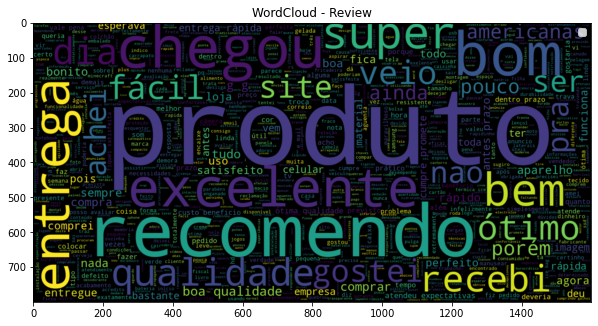

In [39]:
# WordCloud do Review
tokens = []
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
size = len(dfResults.index)
for i in range(size):
    text = dfResults.iloc[i].Review
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(tokens))
plt.title('WordCloud - Review')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


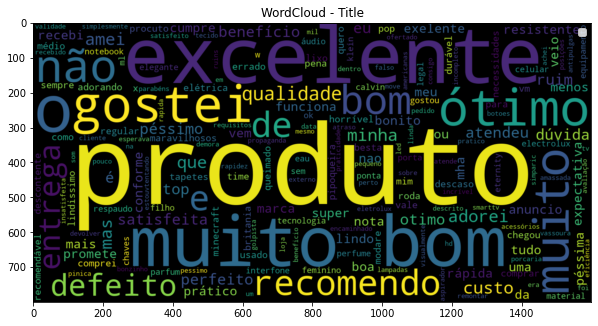

In [40]:
# WordCloud do do Title
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Original))
plt.title('WordCloud - Title')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


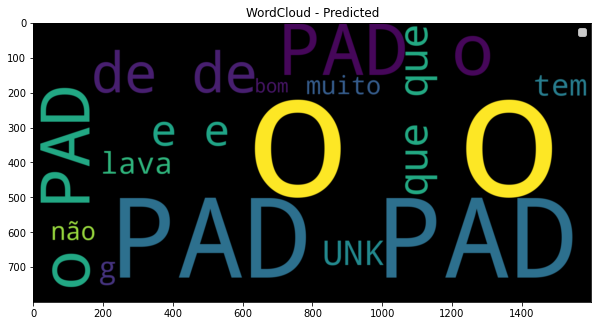

In [41]:
# WordCloud do Predicted (y_test)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Predicted))
plt.title('WordCloud - Predicted')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

In [42]:
# Cálculo da métrica NIST
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':         
            nist = sentence_nist([reference.split()], candidate.split(),1)  
            dfResults.iloc[i,3] = nist
    pbar.update(1)


Métricas para o NIST

Minímo: 0.0
Média: 0.0
Máximo: 0.5
Média: Ponderada 0.1
Desvio Padrão: 0.1
% CV: 241.3765  %



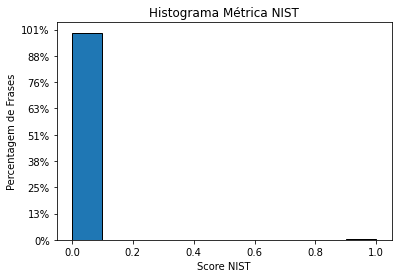

In [43]:
# Relatório do NIST
print("Métricas para o NIST\n")
data = dfResults[dfResults['NIST'].notna()]['NIST'].values
print("Minímo:", round(np.min(data),1))
m = np.mean(data)
print("Média:", round(m,1))
print("Máximo:", round(np.max(data),1))
print("Média: Ponderada", round(m/np.max(data),1))
sdev = round(np.std(data),1)
print("Desvio Padrão:", round(sdev,1))
cv = round((sdev/m)*100,4)
print("% CV:", cv, ' %\n')

aNIST = dfResults[dfResults['NIST'].notna()]['NIST'].values
WordsaNIST = np.round(aNIST.astype(np.double))

num_of_points = len(WordsaNIST)
data = WordsaNIST
fig, ax = plt.subplots()
ax.hist(data,  edgecolor='black')
ax.set_title("Histograma Métrica NIST")
ax.set_xlabel("Score NIST")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [44]:
# Cáclculo da métrica BLEU
err = 0
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
      reference = dfResults.iloc[i].Original
      candidate = dfResults.iloc[i].Predicted
      pbar.update(1)
      if reference != '' and candidate != '':
            cc = SmoothingFunction()
            dfResults.iloc[i,4] = sentence_bleu([reference.split()], candidate.split(),smoothing_function=cc.method1)


Métricas para o BLEU

Minímo: 0
Média: 0.01
Média: Ponderada 0.07
Máximo: 0.1
Desvio Padrão: 0.0
% CV: 284.3  %



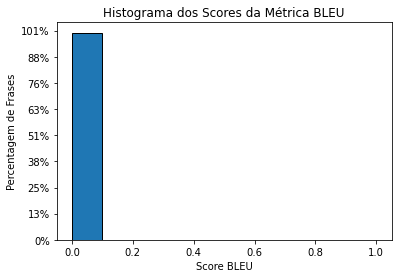

In [45]:
# Relatório do BLEU
print("Métricas para o BLEU\n")
data = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
print("Minímo:", round(np.min(data),1))
m = np.mean(data)
print("Média:", round(m,2))
print("Média: Ponderada", round(m/np.max(data),2))
print("Máximo:", round(np.max(data),1))
sdev = round(np.std(data),4)
print("Desvio Padrão:", round(sdev,1))
cv = round((sdev/m)*100,1)
print("% CV:", cv, ' %\n')
aBLEU = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
WordsaBLEU = np.round(aBLEU.astype(np.double))
num_of_points = len(WordsaBLEU)
num_of_bins = 11
data = WordsaBLEU
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica BLEU")
ax.set_xlabel("Score BLEU")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [46]:
# Cálculo da métrica METEOR
err = 0
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':
            meteor = meteor_score([reference], candidate)  
            dfResults.iloc[i,5] = meteor

    pbar.update(1)

Métricas para o METEOR

Minímo: 0.0
Média: 0.0
Média: Ponderada 0.1
Máximo: 0.2
Desvio Padrão: 0.0
% CV: 281.3  %



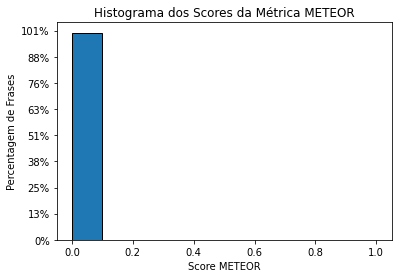

In [47]:
# Relatório do Meteor
print("Métricas para o METEOR\n")
data = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
print("Minímo:", round(np.min(data),1))
m = np.mean(data)
print("Média:", round(m,1))
print("Média: Ponderada", round(m/np.max(data),1))
print("Máximo:", round(np.max(data),1))
sdev = round(np.std(data),4)
print("Desvio Padrão:", round(sdev,1))
cv = round((sdev/m)*100,1)
print("% CV:", cv, ' %\n')
aMETEOR = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
WordsaMETEOR = np.round(aMETEOR.astype(np.double))
num_of_points = len(WordsaMETEOR)
num_of_bins = 11
data = WordsaMETEOR
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica METEOR")
ax.set_xlabel("Score METEOR")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

/anaconda/envs/ep3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/ep3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/anaconda/envs/ep3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/anaconda/envs/ep3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


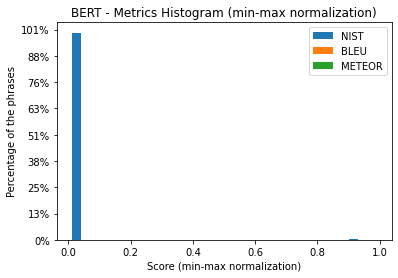

In [48]:
bins = np.linspace(0, 1, 10)
WordsaNISTh = WordsaNIST/np.max(WordsaNIST)
WordsaBLEUh = WordsaBLEU/np.max(WordsaBLEU)
WordsaMETEORh = WordsaMETEOR/np.max(WordsaMETEOR)
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 10)
ax.hist((WordsaNISTh,WordsaBLEUh,WordsaMETEORh), bins,  label=('NIST','BLEU','METEOR'))
ax.legend(loc='upper right')
ax.set_title("BERT - Metrics Histogram (min-max normalization)")
ax.set_xlabel("Score (min-max normalization)")
ax.set_ylabel("Percentage of the phrases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [49]:
# Analise de Tamanho do Title e do Predicted
def dicionarios_size(dfResult):
    Review = []
    Original = []
    fcOriginal = []
    Predicted = []
    fcPredicted = []
    size = len(dfResult.index)
    for i in range(size):
        Review = Review + dfResult.iloc[i].Review.split()
        Original = Original + dfResult.iloc[i].Original.split()
        fcOriginal.append(len(dfResult.iloc[i].Original.split())) 
        Predicted = Predicted + dfResult.iloc[i].Predicted.split()
        fcPredicted.append(len(dfResult.iloc[i].Predicted.split()))
    return len(np.unique(Review)) , len(np.unique(Original)), len(np.unique(Predicted)), fcOriginal,fcPredicted

r, o, p, fco,fcp = dicionarios_size(dfResults)

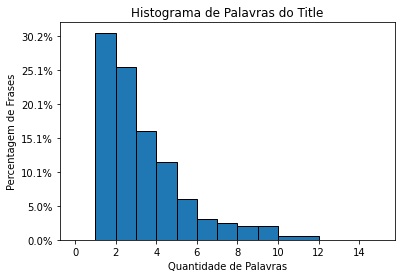

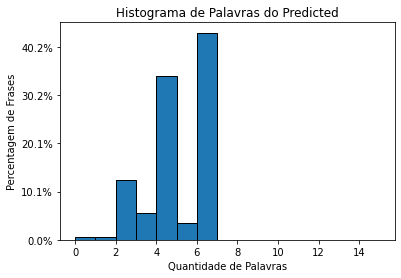


Tamanho de Dicionários
Review: 1149 palavras 
Title: 214 palavras 
Predicted: 18 palavras

Métricas para o Title (em palavras)
Minímo: 1
Média: 2.8141
Máximo: 10
Desvio Padrão: 1.9875
% CV: 70.6272  %

Métricas para o Predicted (em palavras)
Minímo: 0
Média: 4.5578
Máximo: 6
Desvio Padrão: 1.4615
% CV: 32.066  %

Diferença no tamanho do dicionário do Title e do Predicted: 196.0 palavras ou 1088.8889 %
Diferença no tamanho médio entre as frases do Title e do Predicted: -1.7437 palavras ou -38.258 %
Diferença no % CV Máquina entre o Title e do Predicted: 38.5612 % ou relativa: 120.2557 %



In [50]:
# Relatório das medidas de contagem de palabras
Words = fco
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Title")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

Words = fcp
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Predicted")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

print("\nTamanho de Dicionários")
print('Review: ' + str(r) + ' palavras \nTitle: ' + str(o) + ' palavras \nPredicted: ' + str(p)+ ' palavras')

print("\nMétricas para o Title (em palavras)")
print("Minímo:", round(np.min(fco),4))
m = np.mean(fco)
print("Média:", round(m,4))
print("Máximo:", round(np.max(fco),4))
sdev = round(np.std(fco),4)
print("Desvio Padrão:", round(sdev,4))
cvT = round((sdev/m)*100,4)
print("% CV:", cvT, ' %')

print("\nMétricas para o Predicted (em palavras)")
print("Minímo:", round(np.min(fcp),4))
m = np.mean(fcp)
print("Média:", round(m,4))
print("Máximo:", round(np.max(fcp),4))
sdev = round(np.std(fcp),4)
print("Desvio Padrão:", round(sdev,4))
cvP = round((sdev/m)*100,4)
print("% CV:", cvP, ' %\n')

print('Diferença no tamanho do dicionário do Title e do Predicted:',round(np.mean(o)-np.mean(p),4), 'palavras ou' , round((np.mean(o)-np.mean(p))/np.mean(p)*100,4),'%')
print('Diferença no tamanho médio entre as frases do Title e do Predicted:',round(np.mean(fco)-np.mean(fcp),4), 'palavras ou' , round((np.mean(fco)-np.mean(fcp))/np.mean(fcp)*100,4),'%')
print('Diferença no % CV Máquina entre o Title e do Predicted:',round(cvT-cvP,4), '% ou relativa:' , round((cvT-cvP)/cvP*100,4),'%\n')

In [51]:
# Exportação dos resultados do corpo de Teste (corpus, predicted e métricas)
dfResults.to_csv('BERT_b2wCorpusFulldfResults.tsv', sep = '\t',index = False)

In [52]:

runEnd = datetime.now()
runTime = (runEnd - runStart).total_seconds() / 60.0
print("Run time elapsed:",round(runTime,0),'minutes')


Run time elapsed: 5.0 minutes
